<a href="https://colab.research.google.com/github/labviros/computer-vision-topics/blob/master/lesson05-homography/sift_homography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Opencv 3.4.2.16 lib installer

In [1]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20
     |████████████████████████████████| 30.6MB 1.4MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


#Comparing a Ransac Homography implementation with the Opencv Ransac

Direct Linear Transformation Homography:

[[-6.74155442e-02 -4.13303373e+00  1.08413347e+03]
 [-7.29931813e-03 -1.01739231e+00  2.47241064e+02]
 [-1.28910779e-05 -4.00822397e-03  1.00000000e+00]]


My Ransac Homography:

[[ 7.96492826e-01  2.52894897e-02  9.49673723e-01]
 [-6.72188806e-02  8.29048583e-01  1.06277599e+02]
 [-1.58747914e-04  1.87347179e-05  1.00000000e+00]]


Opencv Ransac Homography:

[[ 7.95771426e-01  3.06096897e-02 -1.14389029e+00]
 [-6.88893937e-02  8.24426643e-01  1.08296707e+02]
 [-1.60105922e-04  1.86331919e-05  1.00000000e+00]]




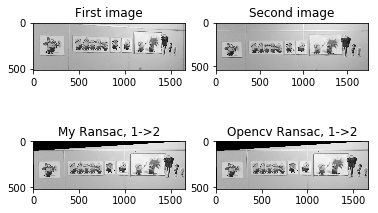

In [16]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imutils
import random as rnd
import math
  
def getNormalizedPoints(kp):
    dis = 0
    dx = np.sum(kp[:,0])/kp.shape[0]
    dy = np.sum(kp[:,1])/kp.shape[0]
    kpn = np.matrix.transpose(np.array([(dx-kp[:,0]),(dy-kp[:,1])]))
    for i in range(0,len(kpn[:,0])):
      dis += np.linalg.norm(kpn[i,:]-[dx,dy])
    scale = math.sqrt(2)*len(kpn[:,0])/dis
    T = np.array([[scale,0,-scale*dx],[0,scale,-scale*dy],[0,0,1]])
    n,m = kp.shape # for generality
    x = np.ones((n,1))
    kpn2 = np.concatenate((kp,x),1)
    kpn2 = np.dot(T,np.transpose(kpn2))
    kpn2 = np.transpose(kpn2)
    kpn3 = kpn2[:,[0,1]]
    return kpn3,T
  
  
def getPerspectiveTransformMatrix(src_pts,dst_pts):
    A = []
    H = []
    p1, T1 = getNormalizedPoints(src_pts)
    p2, T2 = getNormalizedPoints(dst_pts)
    for i in range(0, len(p1)):
      x, y = p1[i][0], p1[i][1]
      u, v = p2[i][0], p2[i][1]
      A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
      A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.asarray(A) # Transforms the column vector into a matrix
    U, S, Vh = np.linalg.svd(A) # SVD of A matrix
    L = Vh[-1,:] / Vh[-1,-1] # Normalizes the last line of V by its last element
    
    Tdot = np.linalg.inv(T2)
    H1 = L.reshape(3, 3) #Reshapes the line into a 3x3 matrix
    H1 = np.dot(Tdot,H1)
    H1 = np.dot(H1,T1)
    H1 = H1/H1[-1,-1]
    return H1

  
def getRansacHomography(src_pts,dst_pts,px_marg,e,p): 
    s = 4
    cont = 0
    n_inl_best = 0
    N = int(abs(math.ceil(math.log(1-p,10)/math.log((1-(1-e)**s),10))))
        
    while (cont<N):
      a = []
      src_inl = []
      dst_inl = []
      for j in range(0,4):
        a.append(rnd.randrange(0,dst_pts.shape[0],1))   #Appends 4 random 
                                                        #positions in the range
                                                        #of good matches
        
      src_pts_rnd = np.array([src_pts[a]]).reshape(4,2)  #Access the random points
      dst_pts_rnd = np.array([dst_pts[a]]).reshape(4,2)  #and reshapes them
      
      Hr = getPerspectiveTransformMatrix(src_pts_rnd, dst_pts_rnd)
      
      m, n = src_pts.shape
      x = np.ones((m,1))                              #Generates a column of ones
      src_pts_2 = np.concatenate((src_pts,x),1)       #Concatenates to get the projection
      src_pts_2 = np.dot(Hr,np.transpose(src_pts_2))  #Hr*[xn,yn,1]
      src_pts_2 = np.transpose(src_pts_2)             #Reorganizes it
      dst_pts_proj = src_pts_2[:,[0,1]]               #Removes the ones column
      
      #Checks if the projected points are inside the established margin px_margin
      for i in range(0,dst_pts.shape[0]):
        if dst_pts_proj[i,0]<=dst_pts[i,0]+px_marg and dst_pts_proj[i,0]>=dst_pts[i,0]-px_marg:
          if dst_pts_proj[i,1]<=dst_pts[i,1]+px_marg and dst_pts_proj[i,1]>=dst_pts[i,1]-px_marg:
            dst_inl.append(dst_pts[i,:])
            src_inl.append(src_pts[i,:])  #If they are, saves the matches
      
      n_inl = len(dst_inl)
      inl_p = (n_inl/dst_pts.shape[0])
      
      #Checks for the current number of inliers
      if n_inl > n_inl_best:
        n_inl_best = n_inl
        src_best = np.asarray(src_inl).reshape(-1,2)
        dst_best = np.asarray(dst_inl).reshape(-1,2)
        
      #Checks the outliers proportion, if better than estimated, calculates new N
      if (1-inl_p)<e:
        e = (1-inl_p)
        N = int(math.ceil(math.log(1-p,10)/math.log((1-(1-e)**s),10)))
      cont += 1
    Hr = getPerspectiveTransformMatrix(src_best, dst_best)
    return Hr
  

#INPUT VARIABLES
################################################################################
MIN_MATCH_COUNT = 10  #Minimun matches for Homography
px_marg = 10          #Pixel margin for Ransac
e = 0.80              #Outlier proportion
p = 0.99              #Probability of outlier-free samples
################################################################################

#img1 = cv.imread('outdoors01.jpg',0) # queryImage
#img2 = cv.imread('outdoors02.jpg',0) # trainImage

img1 = cv.imread('minions01a.jpg',0) # queryImage
img2 = cv.imread('minions02a.jpg',0) # trainImage

#img1 = cv.imread('photo01a.jpg',0) # queryImage
#img2 = cv.imread('photo02a.jpg',0) # trainImage

#img1 = cv.imread('comicsStarWars01.jpg',0) # queryImage
#img2 = cv.imread('comicsStarWars02.jpg',0) # trainImage

#img1 = imutils.rotate_bound(img1,180)

# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# FLANN stands for Fast Library for Approximate Nearest Neighbors. 
# It contains a collection of algorithms optimized for fast nearest neighbor 
# search in large datasets and for high dimensional features. 
# It works faster than BFMatcher for large datasets.
# The variable index_params specifies the algorithm to be used, its related parameters etc. 
# For algorithms like SIFT, SURF etc. you can pass following:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# The variable search_params specifies the number of times the trees in the index should 
# be recursively traversed. Higher values gives better precision, but also takes more time.
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
#bf = cv.BFMatcher()
#matches = bf.knnMatch(des1,des2,k=2)plt.imshow(img3, 'gray')



# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        

if len(good)>MIN_MATCH_COUNT:
    
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)
    
    H = getPerspectiveTransformMatrix(src_pts, dst_pts)
    
    H_ransac = getRansacHomography(src_pts,dst_pts,px_marg,e,p)
    
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    print('Direct Linear Transformation Homography:\n')
    print(H)
    print('\n')
    
    print('My Ransac Homography:\n')
    print(H_ransac)
    print('\n')
    
    print('Opencv Ransac Homography:\n')
    print(M)
    print('\n')
    
    img4 = cv.warpPerspective(img1, H_ransac, (img1.shape[1],img1.shape[0])) #, None) #, flags[, borderMode[, borderValue]]]]	)
    img5 = cv.warpPerspective(img1, M, (img1.shape[1],img1.shape[0])) #, None) #, flags[, borderMode[, borderValue]]]]	)

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
plt.imshow(img1, 'gray')
plt.title('First image')
ax1 = fig.add_subplot(2,2,2)
plt.title('Second image')
plt.imshow(img2,'gray')
ax1 = fig.add_subplot(2,2,3)
plt.title('My Ransac')
plt.imshow(img4,'gray')
ax1 = fig.add_subplot(2,2,4)
plt.title('Opencv Ransac')
plt.imshow(img5,'gray')
plt.show()